# **MO436 - Project 2 - Pokémon RL**

## **Group:**

* Bruno César de Oliveira Souza - 234837

* Henrique Lima Cará de Oliveira - 091518

* Leonardo de Lellis Rossi - 261900

* Maurício Pereira Lopes - 225242

[Git Repository](https://github.com/leolellisr/poke_RL)

Python files of implemented methods available [here](https://github.com/leolellisr/poke_RL/tree/master/py)

Trained models available [here]()

[Graphs ](https://app.neptune.ai/leolellisr/rl-pokeenv)

[Presentation video]()

Images and results are showed with IFrame from IPython.display, but it needs the images stored in the [/images/report](https://github.com/leolellisr/poke_RL/tree/master/images/report) folder, available in our [git repository](https://github.com/leolellisr/poke_RL). 

Images and Results also are presented with links from imgur.

In [1]:
from IPython.display import IFrame

# Goal and Motivation

* This project aims to employ different deep reinforcement learning agents in a Pokémon battle simulator;

* Our motivation is that the deep reinforcement learning trainers show better results than tabular methods from Project 1 and, also, automatically learn, by making decisions through the analysis of states and rewards related to their performance, how to win battles throughout the episodes, noticing:
  * the different types between Pokémon;
  * which moves cause more damage to the opponent's Pokémon;
  * what are the possible strategies using no-damage moves;
  * and the best times to switch Pokémon. 

## **The  problem addressed**
* [Pokémon](https://www.pokemon.com) is a popular Japanese RPG (Role Playing Game) which stands a world championship every year; 
* One single [battle](https://bulbapedia.bulbagarden.net/wiki/Pokémon_battle) of Pokémon has two players. Each player has a 6-Pokémon team; 
* Each Pokémon has:
 * 6 [stats](https://bulbapedia.bulbagarden.net/wiki/Stat) (Health Points, Attack, Defense, Special Attack, Special Defense, Speed). The first 5 are used in the damage calculation. The speed defined which Pokémon moves first in the turn.
  * The Health Points goes from 100% (healthy) to 0% (fainted);
 * 4 possible moves (each with a limited number of uses). Each move has an accuracy, a percentage of success or fail;
 * one [ability](https://bulbapedia.bulbagarden.net/wiki/Ability) that has special effects in the field;
 * one [nature](https://bulbapedia.bulbagarden.net/wiki/Nature) that specifies which stats are higher and which are lower;
 * one [item](https://bulbapedia.bulbagarden.net/wiki/Item), that can  restore Health Points or increase the Power of an Attack.
* The winner of the battle is the player that makes all Pokémon of the oposing team to faint (all oposing Pokémon with health points equals zero, "last man standing" criteria);
* Only one Pokémon of each team can be at the battle field at the same time;
* Every turn, each players select one action: one of the 4 moves of their active Pokémon or [switching](https://bulbapedia.bulbagarden.net/wiki/Recall) for one of other non-fainted Pokémon of their team;

* Pokémon can be summarized as an analyze state (turn) -> take action sequence game. 

* By standard, Pokémon is a stochastic game:
 * One move can have an accuracy value less than 100%, then this move has a probability to be missed;
 * The damage moves (attacks) have the following [damage calculation](https://bulbapedia.bulbagarden.net/wiki/Damage):
  ![Damage](https://wikimedia.org/api/rest_v1/media/math/render/svg/b8c51fed93bb9a80ae8febc13700a40b8a5da402)
  
 where:
  * **[Level](https://bulbapedia.bulbagarden.net/wiki/Level)** (the level of the attacking Pokémon);
  * **A** is the effective Attack stat of the attacking Pokémon if the used move is a physical move, or the effective Special Attack stat of the attacking Pokémon if the used move is a special move;
  * **D** is the effective Defense stat of the target if the used move is a physical move or a special move that uses the target's Defense stat, or the effective Special Defense of the target if the used move is an other special move;
  * **[Power](https://bulbapedia.bulbagarden.net/wiki/Power)** is the effective power of the used move;
  * **Weather** is 1.5 if a Water-type move is being used during rain or a Fire-type move during harsh sunlight, and 0.5 if a Water-type move is used during harsh sunlight or a Fire-type move during rain, and 1 otherwise.
  * **[Critical](https://bulbapedia.bulbagarden.net/wiki/Critical_hit)** has 6.25% chance of occurs and multiplies the damage by 1.5;
  * **random** is a random factor between 0.85 and 1.00 (inclusive):
  * **[STAB](https://bulbapedia.bulbagarden.net/wiki/Same-type_attack_bonus)** is the same-type attack bonus. This is equal to 1.5 if the move's type matches any of the user's types, 2 if the user of the move additionally has the ability Adaptability, and 1 if otherwise;
  * **[Type](https://bulbapedia.bulbagarden.net/wiki/Type)** is the type effectiveness. This can be 0 (ineffective); 0.25, 0.5 (not very effective); 1 (normally effective); 2, or 4 (super effective), depending on both the move's and target's types;
  * **[Burn](https://bulbapedia.bulbagarden.net/wiki/Burn_(status_condition))** is 0.5 (from Generation III onward) if the attacker is burned, its Ability is not Guts, and the used move is a physical move (other than Facade from Generation VI onward), and 1 otherwise.
  * **other** is 1 in most cases, and a different multiplier when specific interactions of moves, Abilities, or items take effect. In this work, this is applied just to Pokémon that has the item **Life Orb**, which multiplies the damage by 1.3.
  
  * **Not** used in this work (equals 1):
   * Targets (for Battles with more than two active Pokémon in the field);
   * Badge ( just applied in Generation II);
   
   

# **MDP formulation and discretization model** 

## Original (stochastic)

We considered our original (stochastic) MDP as a tuple $M = (S, A, \phi, R)$, where:
* **S** is the whole set of possible states. One state **s $\in$ S**  is defined at each turn with 12 battle elements concatenated, that correspond to:
 * [0] Our Active Pokémon index (0: Venusaur,  1: Pikachu, 2: Tauros, 3: Sirfetch'd, 4: Blastoise, 5: Charizard);
 * [1] Opponent Active Pokémon index (0: Eevee,  1: Vaporeon, 2: Leafeon, 3: Sylveon, 4: Jolteon, 5: Umbreon);
 * [2-5] Active Pokémon moves base power (if a move doesn't have base power, default to -1);
 * [6-9] Active Pokémon moves damage multipliers;
 * [10] Our remaining Pokémon;
 * [11] Opponent remaining Pokémon.
 
* **A** is the whole set of possible actions. Our action space is a range [0, 8]. One action **a $\in$ A** is one of the possible choices:
 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.

When a selected action cannot be executed, we random select another possible action.

* **$\phi$** is a stochastic transition function that occurs from state **s** to state **s'**, by taking an action **a**. The following parameters are part of our  stochastic transition function:
 * Move's accuracy (chance of the move successfully occurs or fail);
 * Damage calculation: The **[Critical](https://bulbapedia.bulbagarden.net/wiki/Critical_hit)** parameter (6.25% chance of occurs) and the **random** parameter, ranging from 0.85 and 1.00 (inclusive).
 * Move's effects: Some moves have [additional effects](https://bulbapedia.bulbagarden.net/wiki/Additional_effect). e.g.: Iron Head have 30% chance of flinching the target (target cannot move in the turn).

* **R** is a set of rewards. A reward **r $\in$ R** is acquired in state **s** by taking the action **a**. The rewards are calculated at the end of the turn. The value of reward **r** is defined by the sum of elements:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.
 
### Stochastic Team

Our stochastic team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Team](https://imgur.com/KSXvlmO).

The stochastic opponent team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Opponent Team](https://imgur.com/rLF5Cli).

In [2]:
IFrame("images/report/Team stochastic.png", width=1000, height=600)

In [3]:
IFrame("images/report/Opponent stochastic.png", width=1000, height=600)

## Deterministic

To adapt Pokémon to a deterministic environment, we use Pokémon that cannot receive a critical hit, moves with only 100% accuracy and no side effects, and edit the server code to ignore the random parameter in damage calculation, removing the stochastic transition function $\phi$ from our MDP. Therefore, now our MDP is a tuple $M = (S, A, R)$, where:
* **S** is the whole set of possible states. One state **s $\in$ S**  is defined at each turn with 12 battle elements concatenated, that correspond to:
 * [0] Our Active Pokémon index ;
 * [1] Opponent Active Pokémon index ;
 * [2-5] Active Pokémon moves base power (if a move doesn't have base power, default to -1);
 * [6-9] Active Pokémon moves damage multipliers;
 * [10] Our remaining Pokémon;
 * [11] Opponent remaining Pokémon.
 
* **A** is the whole set of possible actions. Our action space is a range [0, 8] (len: 9). One action **a $\in$ A** is one of the possible choices:
 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.

When a selected action cannot be executed, we random select another possible action.

* **R** is a set of rewards. A reward **r $\in$ R** is acquired in state **s** by taking the action **a**. The rewards are calculated at the end of each turn. The value of reward **r** is defined by the sum of elements:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.
 
### Deterministic Team

Our deterministic team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Team](https://imgur.com/DeRAEQb).

The deterministic opponent team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Opponent Team](https://imgur.com/Hltn5OO).

We use on both teams only Pokémon with [Battle Armor](https://bulbapedia.bulbagarden.net/wiki/Battle_Armor_(Ability)) or [Shell Armor](https://bulbapedia.bulbagarden.net/wiki/Shell_Armor_(Ability)) abilities, which prevent critical hits from being performed. Also, we use in both teams only moves with 100% accuracy, with no chance of getting it missed, and the moves haven't additional effects.

In [4]:
IFrame("images/report/Team deterministic.png", width=1000, height=600)

In [5]:
IFrame("images/report/Opponent deterministic.png", width=1000, height=600)

## Search space

The features that integrate our states are shown in [this figure](https://imgur.com/tREjWCG) and below. For a single battle between two players with 6 Pokémon each, we have $1.016.064$ possible states.

Since we have 9 possible actions, we total $9.144.576$ possibilities for each battle.

In [4]:
IFrame("images/report/possible_states.png", width=920, height=600)

# **The environments built**

The environment used is [Pokémon Showdown](https://play.pokemonshowdown.com), an [open-source](https://github.com/smogon/pokemon-showdown.git) Pokémon battle simulator.

[Example](https://imgur.com/hjHikuc) of one battle in Pokémon Showdown.


In [5]:
IFrame("images/report/showdownEx.jpg", width=1000, height=1000)

To communicate our agents with Pokémon Showdown we used [poke-env](https://poke-env.readthedocs.io/en/latest/) a Python environment for interacting in Pokémon Showdown battles.

We used separated Python classes (available in our [git repository](https://github.com/leolellisr/poke_RL/tree/master/src)) for define the Players that are trained with each method. These classes communicates with Pokémon Showdown and implements the poke-env methods to:
* Create battles;
* Accept battles;
* Send orders (actions) to Pokémon Showdown.

## Original (stochastic)

To speed up the battles, we hosted our own server of Pokemon Showdown in localhost. It requires Node.js v10+.

In [ ]:
git clone https://github.com/smogon/pokemon-showdown.git

After clone the repository, it's needed to create a logs folder in root.

To configure the server, we used the following code:

In [ ]:
cd pokemon-showdown
npm install
cp config/config-example.js config/config.js

To start the server, we use:

In [ ]:
node pokemon-showdown start --no-security

## Deterministic environment

To adapt our environment to a deterministic setup, we had to establish the following parameters:

* We removed the random component of sim/battle.ts from the Pokémon Showdown simulator;

* We use on both teams only Pokémon with Battle Armor or Shell Armor abilities, which prevent critical hits from being performed;

* We used in both teams only moves with 100% accuracy, with no chance of getting it missed;

* We didn't use any move with additional effect. 

# **Characteristics of  the problem**

* Both of our environments (stochastic and deterministic) are episodic. One state occurs after another;

* Our terminal states are:
 * When all our Pokémon are fainted (we lose);
 * When all opponent Pokémon are fainted (we won).

* As specified before, a reward **r** is calculated at the end of a turn (beginning of next turn). The value of reward **r** is defined by the sum of:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.

# gym wrapper

To implement Deep Reinforcement Learning methods in our project, we used poke_env's [env_player class](https://github.com/hsahovic/poke-env/blob/master/src/poke_env/player/env_player.py) as base class. 

The Deep Reinforcement Learning method can be used with the poke_env class by defining our agent as a gym environment to be used in the DeepRL method. 

The class defines an env_algorithm_wrapper for communication between a Pokémon Showdown environment in gym, a Deep Reinforcement Learning method and our agent, that will be used as an environment for the Deep Reinforcement Learning method to states/rewards analysis and decision making.



# **Deep Q-Learning - Keras (2018)**

The first method we have implemented was a **value-based** method: [Deep Q-Learning (DQN), from Keras-RL Agents (2018)](github.com/keras-rl/keras-rl/blob/master/rl/agents/dqn.py).

* Agent performs actions in the environment to learn how to map the observed states to certain actions;
* The agent chooses an action in a given state based on a "Q value" (weighted reward based on the highest expected long-term reward); 
* DQN agent learns to perform its task in such a way that the recommended action maximizes potential future rewards;
* The method is considered an "Off-Policy" method because its Q values are updated assuming the best action was chosen, even if the best action was not chosen.
*  Q-value is calculated with the reward added to the next state maximum Q-value. Every time the Q-value calculates a high number for a certain state, the value that is obtained from the output of the neural network for that specific state, will become higher every time. Each output neuron value will get higher and higher until the difference between each output value is high;
* If action a in state s is a higher value than action b, then action a will get chosen every time for state s. If for some memory experience action b becomes the better action for state s, it is difficult to train the network to learn that action b is the better action in some conditions.

* We used an [linear annealing $\epsilon$-greedy exploration strategy,  from Keras-RL (2018)](https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py), with $\epsilon = 0,1$;

* We used the following $\epsilon$-greedy policy:

In [ ]:
policy = LinearAnnealedPolicy(
            EpsGreedyQPolicy(),
            attr="eps",
            eps = 0.1,
            value_max=1.0,
            value_min=0.05,
            value_test=0,
            nb_steps=10.000 * epochs/10,
        )

We have applied the follow configurations and hyperparameters to the training of this method:
* Optimizer: Adam (Learning Rate: $2.5e-4$)
* Number of the steps in warmup: $10.000 * epochs/10$
* Metric (training): Mean Absolute Error
* gamma = $0.75$
* target_model_update=$1$
* delta_clip=$0.01$
* epsilon (epsilon-greedy policy)=$0.1$  



The internal model of our DQN agent is shown above:

In [ ]:
N_HIDDEN = 128
N_STATE_COMPONENTS = 12
n_action = 9
model = Sequential()
model.add(Dense(N_HIDDEN, activation="elu", input_shape=(1, N_STATE_COMPONENTS)))
# Our embedding have shape (1, 12), which affects our hidden layer dimension and output dimension
# Flattening resolve potential issues that would arise otherwise
model.add(Flatten())
model.add(Dense(int(N_HIDDEN/2), activation="elu"))
model.add(Dense(n_action, activation="linear"))

* Since DQN trains by step and one battle has usually 30 steps, we defined $10.000$ steps per epoch (~$333$ battles per epoch) and defined the total number of battles with the number of epochs. We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $300.000$ steps ($30$ epochs and ~$10.000$ battles) and  $900.000$ steps ($90$ epochs and ~$30.000$ battles). At the end of the $900.000$ steps training, we saved the Keras model for future use;

* We defined one SequentialMemory with limit of the max number of steps ($10.000$ * epochs) and a window length of 1;

In [ ]:
memory = SequentialMemory(limit=10.000 * epochs, window_length=1)

* We defined and compiled our DQN as follows:

In [ ]:
dqn = DQNAgent(
        model=model,
        nb_actions=len(env_player.action_space),
        policy=policy,
        memory=memory,
        nb_steps_warmup=int(10.000 * epochs/10),
        gamma=0.75,
        target_model_update=1,
        delta_clip=0.01,
        enable_double_dqn=False
    )
dqn.compile(Adam(lr=2.5e-4), metrics=["mae"])

* We defined the following algorithms to train and validate our DQN.

In [ ]:
def dqn_training(player, dqn, nb_steps):
    dqn.fit(player, nb_steps=nb_steps)
    player.complete_current_battle()

def dqn_evaluation(player, dqn, nb_episodes):
    # Reset battle statistics
    player.reset_battles()
    dqn.test(player, nb_episodes=nb_episodes, visualize=False)

Finally, we call the following functions to train and test our agent:

In [ ]:
# Training
env_player.play_against(
    env_algorithm=dqn_training,
    opponent=opponent_player,
    env_algorithm_kwargs={"dqn": dqn, "nb_steps": int(10.000 * epochs/10)},
)
model.save("model_%d" % int(10.000 * epochs/10))

# Evaluation
env_player.num_battles=0
env_player.play_against(
    env_algorithm=dqn_evaluation,
    opponent=opponent,
    env_algorithm_kwargs={"dqn": dqn, "nb_episodes": int(number_of_battles/3)})

* We validate our solution in both cases against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-184/charts. 

The agent trained for $300k$ steps and $10.077$ battles, resulting in ~$29,77$ steps per battle.
 
### **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Rewards (per step) - Training 

[**Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/ixM6ErF)

In [6]:
IFrame("images/report/reward_computed_dqn_sto.png", width=800, height=600)

### **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages (per battle) - Training
[ **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/IASqmaj)

In [7]:
IFrame("images/report/win_acc_dqn_sto.png", width=1000, height=600)

### **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2319/3286$ battles [this is $69,57\%$ and took $12.699$ seconds]

### Versus RandomPlayer
* Player won $3286/3333$ battles [this is $98,59\%$ and took $12.459$ seconds]



### **Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Memory and CPU usage (absolute time) - Training

[**Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Memory and CPU usage (absolute time) - Training](https://imgur.com/WicjMaW)

In [8]:
IFrame("images/report/cpu and memory dqn keras sto.png", width=1000, height=600)

## **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-189/charts.

The agent trained for $300k$ steps and $13.021$ battles, resulting in ~$23,04$ steps per battle.

### **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Rewards (per step) - Training 

[**Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/AqsupVL)

In [15]:
IFrame("images/report/reward_computed_dqn_det.png", width=800, height=600)

### **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages (per battle) - Training
[ **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/rYU76ax)

In [16]:
IFrame("images/report/win_acc_dqn_det.png", width=1000, height=600)

### **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2390/3333$ battles [this is $71,71\%$ and took $11.016$ seconds]

### Versus RandomPlayer
* Player won $3283/3333$ battles [this is $98,50\%$ and took $12.889$ seconds]

### **Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Memory and CPU usage  (absolute time) - Training

[**Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Memory and CPU usage (absolute time) - Training](https://imgur.com/yJflda0)

In [17]:
IFrame("images/report/cpu and memory dqn keras det.png", width=1000, height=600)

## **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-185/charts. 

The agent trained for $900k$ steps and $29.979$ battles, resulting in ~$30,02$ steps per battle.

### **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Rewards (per step) - Training 

[**Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/bhxDe1S)

In [ ]:
IFrame("images/report/reward_computed_dqn_sto90.png", width=800, height=600)

### **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages (per battle) - Training
[ **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/NaWa56r)

In [ ]:
IFrame("images/report/win_acc_dqn_sto90.png", width=1000, height=600)

### **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2032/3333$ battles [this is $60,57\%$ and took $36.988$ seconds]

### Versus RandomPlayer
* Player won $3309/3333$ battles [this is $99,28\%$ and took $39.774$ seconds]


### **Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Memory and CPU usage (absolute time) - Training

[**Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Memory and CPU usage (absolute time) - Training](https://imgur.com/8kG2OlA)


In [ ]:
IFrame("images/report/cpu and memory dqn keras sto90.png", width=1000, height=600)

## **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-190/charts. 

The agent trained for $900k$ steps and $38.922$ battles, resulting in ~$23,12$ steps per battle.

### **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Rewards (per step) - Training 

[**Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/f1sQsub)

In [ ]:
IFrame("images/report/reward_computed_dqn_det90.png", width=800, height=600)

### **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages (per battle) - Training
[ **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/Ulx7nYp)

In [ ]:
IFrame("images/report/win_acc_dqn_det90.png", width=1000, height=600)

### **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2487/3333$ battles [this is $74,62\%$ and took $41.872$ seconds]

### Versus RandomPlayer
* Player won $3296/3333$ battles [this is $98,89\%$ and took $45.381$ seconds]

### **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Memory and CPU usage (absolute time) - Training

[**Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Memory and CPU usage (absolute time) - Training](https://imgur.com/WPaX7kJ)


In [ ]:
IFrame("images/report/cpu and memory dqn keras det90.png", width=1000, height=600)

# **Double Deep Q-Learning - Keras (2018)**

The second method we have implemented also is a **value-based** method: [Double Deep Q-Learning (DQN), from Keras-RL Agents (2018)](github.com/keras-rl/keras-rl/blob/master/rl/agents/dqn.py). We used the same code from DQN.

* Double DQN uses two identical neural network models. One learns during the experience replay, just like DQN does, and the other one is a copy of the last episode of the first model. The Q-value is actually computed with this second model;
* As DQN, agent performs actions in the environment to learn how to map the observed states to certain actions, chooses an action in a given state based on a "Q value" (weighted reward based on the highest expected long-term reward) and learns to perform its task in such a way that the recommended action maximizes potential future rewards;
* Differently from DQN, if action a in state s is a higher value than action b, we use a secondary model that is the copy of the main model from the last episode and, since the difference between values of the second model are lower than the main model, we use this second model to attain the Q-value;
* Double DQN calculates Q-value finding the index of the highest Q-value from the main model and then using that index to obtain the action from the second model;
* The method is considered an "Off-Policy" method because its Q values are updated assuming the best action was chosen, even if the best action was not chosen.

*  As DQN, we used an [linear annealing $\epsilon$-greedy exploration strategy,  from Keras-RL (2018)](https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py), with $\epsilon = 0,1$;

* We also used the following $\epsilon$-greedy policy:

In [ ]:
policy = LinearAnnealedPolicy(
            EpsGreedyQPolicy(),
            attr="eps",
            eps = 0.1,
            value_max=1.0,
            value_min=0.05,
            value_test=0,
            nb_steps=10.000 * epochs/10,
        )

We have applied the follow configurations and hyperparameters to the training of this method:
* Optimizer: Adam (Learning Rate: $2.5e-4$)
* Number of the steps in warmup: $10.000 * epochs/10$
* Metric (training): Mean Absolute Error
* gamma = $0.75$
* target_model_update=$1$
* delta_clip=$0.01$
* epsilon (epsilon-greedy policy)=$0.1$  



The internal model of our Double DQN agent is shown above:

In [ ]:
N_HIDDEN = 128
N_STATE_COMPONENTS = 12
n_action = 9
model = Sequential()
model.add(Dense(N_HIDDEN, activation="elu", input_shape=(1, N_STATE_COMPONENTS)))
# Our embedding have shape (1, 12), which affects our hidden layer dimension and output dimension
# Flattening resolve potential issues that would arise otherwise
model.add(Flatten())
model.add(Dense(int(N_HIDDEN/2), activation="elu"))
model.add(Dense(n_action, activation="linear"))

* Since Double DQN trains by step and one battle has usually 30 steps, we defined $10.000$ steps per epoch (~$333$ battles per epoch) and defined the total number of battles with the number of epochs. We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $300.000$ steps ($30$ epochs and ~$10.000$ battles) and $900.000$ steps ($90$ epochs and ~$30.000$ battles). At the end of the $900.000$ steps training, we saved the Keras model for future use;

* We defined one SequentialMemory with limit of the max number of steps ($10.000$ * epochs) and a window length of 1;


In [ ]:
memory = SequentialMemory(limit=10.000 * epochs, window_length=1)

* We defined and compiled our Double DQN as follows:

In [ ]:
dqn = DQNAgent(
        model=model,
        nb_actions=len(env_player.action_space),
        policy=policy,
        memory=memory,
        nb_steps_warmup=int(10.000 * epochs/10),
        gamma=0.75,
        target_model_update=1,
        delta_clip=0.01,
        enable_double_dqn=True
    )
dqn.compile(Adam(lr=2.5e-4), metrics=["mae"])

* We defined the following algorithms to train and validate our Double DQN.

In [ ]:
def dqn_training(player, dqn, nb_steps):
    dqn.fit(player, nb_steps=nb_steps)
    player.complete_current_battle()

def dqn_evaluation(player, dqn, nb_episodes):
    # Reset battle statistics
    player.reset_battles()
    dqn.test(player, nb_episodes=nb_episodes, visualize=False)


Finally, we call the following functions to train and test our agent:

In [ ]:
# Training
env_player.play_against(
    env_algorithm=dqn_training,
    opponent=opponent_player,
    env_algorithm_kwargs={"dqn": dqn, "nb_steps": int(10.000 * epochs/10)},
)
model.save("model_%d" % int(10.000 * epochs/10))

# Evaluation
env_player.num_battles=0
env_player.play_against(
    env_algorithm=dqn_evaluation,
    opponent=opponent,
    env_algorithm_kwargs={"dqn": dqn, "nb_episodes": int(number_of_battles/3)})

* We validate our solution in both cases against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-152/charts. 

The agent trained for $300k$ steps and $10.053$ battles, resulting in ~$29,84$ steps per battle.


### **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Rewards (per step) - Training 

[**Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/uyBq9GJ)

In [ ]:
IFrame("images/report/reward_computed_double_dqn_sto.png", width=800, height=600)

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages (per battle) - Training
[ **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/gxOglQv)

In [ ]:
IFrame("images/report/win_acc_double_dqn_sto.png", width=1000, height=600)

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2233/3333$ battles [this is $67\%$ and took $9.750$ seconds]

### Versus RandomPlayer
* Player won $3266/3333$ battles [this is $98\%$ and took $14.001$ seconds]

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Memory and CPU usage (absolute time) - Training

[**Double Deep Q-Learning - Keras (2018)** 300k steps - Stochastic - Memory and CPU usage (absolute time) - Training](https://imgur.com/rKdi5DW)

In [ ]:
IFrame("images/report/cpu and memory double dqn keras sto.png", width=1000, height=600)

## **Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-192/charts.

The agent trained for $300k$ steps and $13.006$ battles, resulting in ~$23,07$ steps per battle.

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Rewards (per step) - Training 

[**Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/cviU2k5)


In [ ]:

IFrame("images/report/reward_computed_double_dqn_det.png", width=800, height=600)


### **Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages (per battle) - Training
[**Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/g1UqVF4)

In [ ]:
IFrame("images/report/win_acc_double_dqn_det.png", width=1000, height=600)

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2569/3333$ battles [this is $77,08\%$ and took $11.508$ seconds]

### Versus RandomPlayer
* Player won $3312/3333$ battles [this is $99,37\%$ and took $13.261$ seconds]

### **Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Memory and CPU usage  (absolute time) - Training

[**Double Deep Q-Learning - Keras (2018)** 300k steps - Deterministic - Memory and CPU usage (absolute time) - Training](https://imgur.com/wtXIKni)

In [ ]:
IFrame("images/report/cpu and memory double dqn keras det.png", width=1000, height=600)

## **Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-168/charts. 

The agent trained for $300k$ steps and $30.049$ battles, resulting in ~$29,95$ steps per battle.


### **Double Deep Q-Learning - Keras (2018)** 900k steps  - Stochastic - Rewards (per step) - Training 

[**Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/sD2rnhb)

In [ ]:
IFrame("images/report/reward_computed_double_dqn_sto90.png", width=800, height=600)


### **Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages (per battle) - Training
[ **Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/1HEDLLU)

In [ ]:

IFrame("images/report/win_acc_double_dqn_sto90.png", width=1000, height=600)

### **Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2798/3333$ battles [this is $83,94\%$ and took $26.557$ seconds]

### Versus RandomPlayer
* Player won $3308/3333$ battles [this is $99,24\%$ and took $28.491$ seconds]



### **Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Memory and CPU usage (absolute time) - Training

[**Double Deep Q-Learning - Keras (2018)** 900k steps - Stochastic - Memory and CPU usage (absolute time) - Training](https://imgur.com/cUSo9hB)

In [ ]:
IFrame("images/report/cpu and memory double dqn keras sto90.png", width=1000, height=600)

## **Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-191/charts.

The agent trained for $900k$ steps and $38.932$ battles, resulting in ~$23,12$ steps per battle.

### **Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Rewards (per step) - Training 

[**Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/IWHPKKl)

In [ ]:
IFrame("images/report/reward_computed_double_dqn_det90.png", width=800, height=600)

### **Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages (per battle) - Training
[**Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/Nd1m6aw)

In [ ]:
IFrame("images/report/win_acc_double_dqn_det90.png", width=1000, height=600)

### **Double Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2597/3333$ battles [this is $77,92\%$ and took $46.701$ seconds]

### Versus RandomPlayer
* Player won $3299/3333$ battles [this is $98,98\%$ and took $61.444$ seconds]

### **Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Memory and CPU usage  (absolute time) - Training

[**Deep Q-Learning - Keras (2018)** 900k steps - Deterministic - Memory and CPU usage (absolute time) - Training](https://imgur.com/EzSWLC9)

In [ ]:
IFrame("images/report/cpu and memory double dqn keras det90.png", width=1000, height=600)

# ** Proximal Policy Optimization (PPO2) - Stable Baselines (2021)**

The last method we have implemented was a **policy-based** method: [Proximal Policy Optimization (PPO2), from Stable Baselines (2021)](github.com/Stable-Baselines-Team/stable-baselines/blob/master/stable_baselines/ppo2/ppo2.py).

* The Proximal Policy Optimization algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).
* The main idea is that after an update, the new policy should be not too far from the old policy. For that, PPO uses clipping to avoid too large update;
* Proximal Policy Optimization (PPO) is an Actor-Critic method. As the name suggests, the Actor-Critic system has two models: the Actor and the Critic. The Actor corresponds to the policy and is used to choose the action for the agent and update the policy network. The Critic corresponds to the value function. The Critic updates the parameters of the network for the value function used during the Actor update. The actor network receives observation (state) as the input and outputs a list of probabilities, with one probability per action. These probabilities form a distribution, and the action can then be chosen by sampling from this distribution. To represent the state value function, the critic network also receives the state as the input and outputs a single number representing the estimated state value of that state.

* We used an [MlpPolicy,  Stable Baselines (2021)](https://github.com/Stable-Baselines-Team/stable-baselines/blob/master/stable_baselines/deepq/policies.py), a policy object that implements DQN policy, using a MLP (2 layers of 64).

We have applied the follow configurations and hyperparameters to the training of this method:
* Optimizer: Adam (Learning Rate: $2.5e-4$)
* gamma = $0.75$
* clip_range=$0.2$

Since PPO also trains by step and one battle has usually 30 steps, we defined $10.000$ steps per epoch (~$333$ battles per epoch) and defined the total number of battles with the number of epochs. We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles ($30$ epochs) and $30.000$ battles ($90$ epochs. At the end of the $30.000$ battles training, we saved the PPO model for future use;

* We defined our PPO as follows:

In [ ]:
model = PPO2("MlpPolicy", env_player, gamma=0.75, verbose=0)

* We defined the following algorithms to train and validate our PPO.

In [ ]:
NB_TRAINING_STEPS = args.epochs*10000
NB_EVALUATION_EPISODES = int(10000/3)
def ppo_training(player):
        print ("Training...")
        model.learn(total_timesteps=NB_TRAINING_STEPS)
        print("Training complete.")
        
def ppo_evaluating(player):
        player.reset_battles()
        for _ in range(NB_EVALUATION_EPISODES):
            done = False
            obs = player.reset()
            while not done:
                action = model.predict(obs)[0]
                obs, _, done, _ = player.step(action)
                # print ("done:" + str(done))
        player.complete_current_battle()

        print(
            "PPO Evaluation: %d victories out of %d episodes"
            % (player.n_won_battles, NB_EVALUATION_EPISODES)
        )


Finally, we call the following functions to train and test our agent:

In [ ]:
# Training
env_player.play_against(
    env_algorithm=ppo_training,
    opponent=opponent
)
model.save("model_%d" % NB_TRAINING_STEPS)

# Evaluation
env_player.mode = "val_max"
print("Results against max player:")
env_player.num_battles=0
env_player.play_against(
    env_algorithm=ppo_evaluating,
    opponent=opponent)
env_player.mode = "val_rand"

print("\nResults against random player:")
env_player.num_battles=0
env_player.play_against(
    env_algorithm=ppo_evaluating,
    opponent=second_opponent)

* We validate our solution in both cases against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Results 

The graphs of "Rewards in Training" and "Wins in Training" can be seen at . 


The agent trained for $300k$ steps and $10.077$ battles, resulting in ~$29,77$ steps per battle.


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Rewards (per step) - Training 

[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/NzIOSBP)


In [ ]:
IFrame("images/report/reward_computed_MC_Control.png", width=800, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Win percentages (per step) - Training
[ **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/IJefGsi)


In [ ]:
IFrame("images/report/win_acc_MC_Control.png", width=1000, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $1262/3333$ battles [this is $37.86\%$ and took $743.18$ seconds]

### Versus RandomPlayer
* Player won $3026/3333$ battles [this is $90.79\%$ and took $841.88$ seconds]



## **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training" and "Wins in Training" can be seen at .

The agent trained for $300k$ steps and $14.000$ battles, resulting in ~$21,43$ steps per battle.

### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Rewards (per step) - Training 

[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/38rgkAO)


In [ ]:
IFrame("images/report/ppo_results/rewards_ppo_deterministic_10k_battles.pdf", width=800, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Win percentages (per step) - Training
[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/at7H6gL)


In [ ]:
IFrame("images/report/ppo_results/win_ppo_deterministic_10k_battles.pdf", width=800, height=600)


###  **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 300k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $2495/3333$ battles [this is $74,86\%$ and took $2400$ seconds]

### Versus RandomPlayer
* Player won $3324/3333$ battles [this is $99,73\%$ and took $3600$ seconds]


## **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Results 

The graphs of "Rewards in Training" and "Wins in Training" can be seen at . 


The agent trained for $900k$ steps and $10.077$ battles, resulting in ~$29,77$ steps per battle.


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Rewards (per step) - Training 

[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Rewards (per step) - Training](https://imgur.com/NzIOSBP)


In [ ]:
IFrame("images/report/reward_computed_MC_Control.png", width=800, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Win percentages (per step) - Training
[ **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Win percentages (per step) - Training](https://imgur.com/IJefGsi)

In [ ]:
IFrame("images/report/win_acc_MC_Control.png", width=1000, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player won $1262/3333$ battles [this is $37.86\%$ and took $743.18$ seconds]

### Versus RandomPlayer
* Player won $3026/3333$ battles [this is $90.79\%$ and took $841.88$ seconds]



## **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Results 

The instant values of the graphs of "Rewards in Training" and "Wins in Training" can be seen at .

The agent trained for $900k$ steps and $10.077$ battles, resulting in ~$29,77$ steps per battle.

### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Rewards (per step) - Training 

[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Rewards (per step) - Training](https://imgur.com/SK4jm8B)


In [ ]:
IFrame("images/report/reward_computed_MC_Control_deterministic.png", width=800, height=600)


### **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Win percentages (per step) - Training
[**Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Win percentages (per step) - Training](https://imgur.com/p1zFpu6)


In [ ]:
IFrame("images/report/win_acc_MC_Control_deterministic.png", width=1000, height=600)


###  **Proximal Policy Optimization (PPO2) - Stable Baselines (2021)** 900k steps - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player won $1201/3333$ battles [this is $36.03\%$ and took $400.07$ seconds]

### Versus RandomPlayer
* Player won $2997/3333$ battles [this is $89.92\%$ and took $720$ seconds]


# Limitations

As our previous project, the only limitations of this project are in the use of the **deterministic** environment. Given the need to remove **randomness**, our deterministic solutions require the use of modified Pokémon Showdown, without the random parameter in damage calculation, and the Pokémon on both teams with:
- Shell Armor or Battle Armor abilities, to prevent critical hits;
- Moves with 100% accuracy and no side effects likely to occur.

Our **stochastic** solutions can be applied to any case and with any team formation.


# Related work

Given the stochasticity of the Pokémon game, the environment proves to be a good alternative to validate more robust reinforcement learning systems. However, in recent years, few reinforcement learning works have been willing to use Pokémon battles to validate their models.

Regarding tabular methods, the work of [Rill-García, R. 2018](https://ccc.inaoep.mx/~esucar/Clases-mgp/Proyectos/2018/reinforcement-learning-turn%20%281%29.pdf) can be mentioned. The author proposes the use of the Q-Learning algorithm. The author defines as states only the index of his active Pokémon and the opponent's. However, 301 Pokémon are considered to choose from, among the most used in competitive battles. Actions were also defined from 601 moves most used in competitive battles, plus one, referring to an action that cannot be performed. Rewards were set based on the Pokémon that passed out (their or the opponent's), the percentages of damage produced or taken, and based on an "unable to act" rating. The author used constant values of $\alpha = 0.1$ and $\gamma = 0.8$. The author used 10 different teams for validation and reported an average of $58\%$ wins against a RandomPlayer (player who selects random actions at each turn).

Another tabular method that can be cited is the work of [Kalose, A et. al. 2018](https://web.stanford.edu/class/aa228/reports/2018/final151.pdf). The authors also propose the use of the Q-Learning algorithm, however, it uses two different policies, an $\epsilon-greedy$ and a Softmax. The authors define as states the Health Points of their Pokémon, the Health Points of the opponent's Pokémon, the types of their Pokémon and the types of opponent's Pokémon. The defined actions are the 4 possible moves of each Pokemon. The authors did not establish how the rewards were defined, or the $\alpha$ and $\gamma$ values used. The authors reported an average of $60\%$ winnings against a RandomPlayer (player who selects random actions each turn) using $\epsilon-greedy$ policy and $68\%$ winnings against a RandomPlayer using Softmax policy.


# Comparisons

One table with performance comparisons in Validation between our methods and the methods proposed by Rill-Garcia and Kalose et. al. are showed below and in [this figure](https://imgur.com/vwUOnDZ).

The method with the best performance against both Players (MaxDamagePlayer and RandomPlayer) was Q-Learning Function Approximation in the Stochastic environment.

In [78]:
IFrame("images/report/comparisons_val.png", width=1000, height=1000)

# Video

https://youtu.be/uSZE9gnheSI


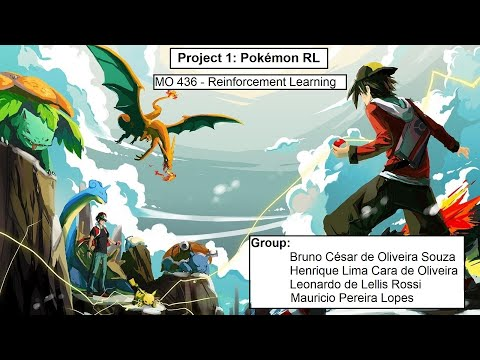

In [82]:
from IPython.display import YouTubeVideo

YouTubeVideo('uSZE9gnheSI', width=960, height=540)

# Discussion


Differently from the works found in the literature, which train and validate their models only against a RandomPlayer, our methods were trained against a MaxDamagePlayer and validated against a MaxDamagePlayer and against a RandomPlayer, showing significant improvements. All of our implemented methods showed better results than a RandomPlayer with the same battle configurations.

Our Monte-Carlo Control 1st Visit agent, in a stochastic environment, averaged $34.91\%$ wins against a MaxDamagePlayer and $92.7\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $39.4\%$ wins against a MaxDamagePlayer and $90.57\%$ wins against a RandomPlayer. In a visual analysis of the battles, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. Compared to the other implemented methods, the agent with Monte-Carlo was the one with the worst performance against MaxDamagePlayer. We hypothesize that this occurs because Monte-Carlo methods occur through sampling, acquiring the rewards and updating their tables only at the end of each episode. In a battle against MaxDamagePlayer, this can demonstrate a negative performance, as MaxDamagePlayer always selects attacks with the highest Base Power, which can cause the end of a battle very quickly, making it difficult for the agent to define the best strategy. This lack of bootstrapping, however, allows the method to have a good convergence, performing well against a RandomPlayer.


Our Monte-Carlo Control 1st Visit with Function Approximation agent, in a stochastic environment, averaged $83.46\%$ wins against a MaxDamagePlayer (improving by $48.55\%$ compared to the agent without Function Approximation) and $92.7\%$ wins against a RandomPlayer (improving by $6.52\%$ compared to the agent without Function Approximation). In a deterministic environment, the agent averaged $60.05\%$ (improving by $20.64\%$ compared to the agent without Function Approximation) wins against a MaxDamagePlayer and $99.29\%$ wins against a RandomPlayer (improving by $8.72\%$ compared to the agent without Function Approximation). We noticed that our Feature Vector performed very well in generalizing our states (out of $1,016,064$ possible states). As in the method without Function Approximation, in a visual analysis of the battles, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. 


Our Q-Learning agent, in a stochastic environment, averaged $41.69\%$ wins against a MaxDamagePlayer and $90.04\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $39.84\%$ wins against a MaxDamagePlayer and $85.36\%$ wins against a RandomPlayer. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. In addition, the agent made good use of Pokémon abilities to lower the opponent's attack stat. The agent also used Roost (recover Health Points) and Sleep Powder (cause status to the opponent) several times. This is because our rewards have parameters in these cases (HP value and opponent's status). As Q-Learning looks for the best reward in each state, the agent took advantage of the execution of these moves to maximize its rewards.

Our Q-Learning with Function Approximation agent, in a stochastic environment, averaged $83.84\%$ wins against a MaxDamagePlayer (improving by $42.15\%$ compared to the agent without Function Approximation) and $99.22\%$ wins against a RandomPlayer (improving by $9.18\%$ compared to the agent without Function Approximation). In a deterministic environment, the agent averaged $58.73\%$ wins against a MaxDamagePlayer (improving by $18.89\%$ compared to the agent without Function Approximation) and $99.34\%$ wins against a RandomPlayer (improving by $13.98\%$ compared to the agent without Function Approximation), being the agent that showed the best performance in an average of all executed battles. This demonstrates again that our Feature Vector performed very well in generalizing our states. Furthermore, we hypothesize that, as Q-Learning has bootstrapping, it was able to generalize well the seen states in order to maximize their rewards. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to Pokémon with super-effective attacks against the opponent. Also, the agent made a lot of use of the Giga Drain damage move (promotes damage and recovers HP), even when this move wasn't very effective. We hypothesize that this occurs because the Player realized that, even if the move was not very effective, it promoted a decrease in the opponent's Health Points and an increase in ours, promoting greater rewards.

Our SARSA($\lambda$) agent, in a stochastic environment, averaged $54.79\%$ wins against a MaxDamagePlayer and $90.94\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $52.93\%$ wins against a MaxDamagePlayer and $99.34\%$ wins against a RandomPlayer, being the best performing tabular method against MaxDamagePlayer. In a visual analysis of the battles, the agent made a lot of use of non-damage move Leech Seed, which removes the opponent's Health Points in each battle and adds them to ours. This is because our rewards have parameters in these cases (+ our HP and - opponent's HP). The agent also used the non-damage move Sunny Day when the opponent was with a Water-type Pokémon, causing the attacks of this opposing Pokémon to decrease its Base Power. As requested in the project specification, we use the same step-size and exploration schedules as the Monte-Carlo method. For this, the same base class was used in both agents.

Our SARSA($\lambda$) with Function Approximation agent, in a stochastic environment, averaged $83.46\%$ wins against a MaxDamagePlayer (improving by $28.67\%$ compared to the agent without Function Approximation) and  $61.21\%$ wins against a RandomPlayer (decreasing by $33.63\%$ compared to the agent without Function Approximation, being the only case where a method with Function Approximation performed worse than the method without Function Approximation). We hypothesized that this happened because, as SARSA($\lambda$) is bootstrapped, the method may have become biased due to the training being done against a MaxDamagePlayer, and thus, our Feature Vector was not sufficient to generalize well with a RandomPlayer. Also, as the environment is stochastic, it's possible that our Player missed the attacks. In a deterministic environment, the agent averaged $61.21\%$ wins against a MaxDamagePlayer (improving by $8.28\%$ compared to the agent without Function Approximation) and $99.13\%$ wins against a RandomPlayer (improving by $9.65\%$ compared to the agent without Function Approximation). The good performance of the agent in a deterministic environment in relation to the method without Function Approximation corroborates our hypothesis that our agent may have missed attacks due to the randomity of the stochastic environment. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to Pokémon with super-effective attacks against the opponent. Also, the agent made a lot of use of the Giga Drain damage move (promotes damage and recovers HP), even when this move wasn't very effective.

# Conclusion

Given the complexity of a Pokémon battle (as shown, $1,016,064$ states and $9,144,576$ possibilities), the implemented methods were able to generalize the states and explore the best reward acquisitions, with all methods performing better than a RandomPlayer. The methods showed increasing learning, in view of the increase in rewards and victory rate as battles went on.

Particularly, the methods that used Function Approximation found it easier to generalize the states, given the influence of our Features Vector, since the tabular methods find it difficult to generalize the millions of possibilities in a few battles ($10k$).

In addition to the difference in training and validating using a MaxDamagePlayer (getting good results), most of our methods presented better performances than related works.

As future work, we propose the exploration of specific parameters for each method. Following the guidelines of the project specifications, the same parameters defined for Monte-Carlo Control were used. However, some methods can take better advantage of other parameters, such as SARSA($\lambda$), which is very dependent on the value set for $\lambda$. We also propose to consider in the observations the types of Pokémon, their abilities and possible side effects of moves.

# Contributions

## Methods

### Deep Q-Learning
* **Code development**: Leonardo;
* **Code review**: Bruno, Henrique, Maurício;
* **Experiments**: Leonardo.

### Double Deep Q-Learning
* **Code development**: Leonardo;
* **Code review**: Bruno, Henrique, Maurício;
* **Experiments**: Leonardo.

## Video
* **Editing**: Leonardo;
* **Review**: Bruno, Henrique, Maurício.

## Report
* **Writting**: Bruno, Henrique, Leonardo, Maurício.
